<a href="https://colab.research.google.com/github/HenrySomeCode/VAE_fake_handwritten_digits/blob/main/VAE_fake_handwritten_digits.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install tensorflow-probability

In [ ]:
!pip install imageio
!pip install git+https://github.com/tensorflow/docs

In [3]:
from IPython import display 
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
import tensorflow_probability as tfp
import time

In [4]:
(train_images, _), (test_images, _) = tf.keras.datasets.mnist.load_data()

11490434/11490434 [==============================] - 0s 0us/step


In [5]:
train_images.shape

(60000, 28, 28)

In [6]:
def preprocess_images(images):
    # the '1' in (images.shape[0],28,28,1) represents channel dimension
    images = images.reshape((images.shape[0],28,28,1))/255
    #pixel values > 0.5 in converted to 1, otherwise it's 0
    return np.where(images > .5, 1.0, 0.0). astype('float32') 

In [7]:
train_images = preprocess_images(train_images)
test_images = preprocess_images(test_images)

In [8]:
train_size = 60000
batch_size = 32
test_size = 10000

In [9]:
# ???
train_dataset = (tf.data.Dataset.from_tensor_slices(train_images)
                 .shuffle(train_size).batch(batch_size))
test_dataset = (tf.data.Dataset.from_tensor_slices(test_images)
                .shuffle(test_size).batch(batch_size))

Encoder : 

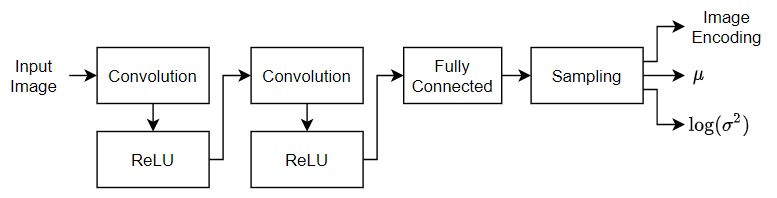



Decoder:

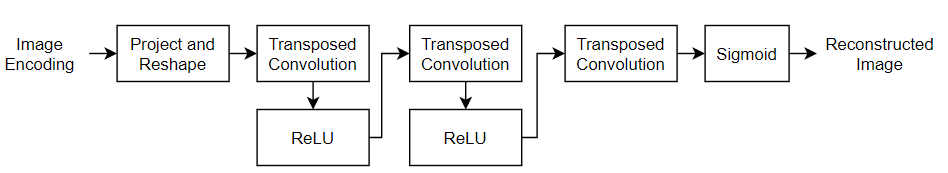

[Ref: https://www.mathworks.com/help/deeplearning/ug/train-a-variational-autoencoder-vae-to-generate-images.html ]

In [10]:
class CVAE(tf.keras.Model):
    def __init__(self, latent_dim):
        super(CVAE, self).__init__()
        self.latent_dim = latent_dim
        self.encoder = tf.keras.Sequential([
            tf.keras.layers.InputLayer(input_shape=(28,28,1)),
            tf.keras.layers.Conv2D(
                filters = 32, kernel_size=3, strides=(2,2), activation ='relu'
            ),
            tf.keras.layers.Conv2D(
                filters = 64, kernel_size = 3, strides=(2,2), activation='relu'
            ),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(latent_dim + latent_dim)
        ])

        self.decoder = tf.keras.Sequential([
            tf.keras.layers.InputLayer(input_shape = (latent_dim,)),
            tf.keras.layers.Dense(units=7*7*32, activation=tf.nn.relu),
            tf.keras.layers.Reshape(target_shape=(7,7,32)),
            tf.keras.layers.Conv2DTranspose(
                filters=64,kernel_size=3, strides=2, padding='same',activation='relu'
            ),
            tf.keras.layers.Conv2DTranspose(
                filters=32,kernel_size=3, strides=2, padding='same',activation='relu'
            ),
            tf.keras.layers.Conv2DTranspose(
                filters=1,kernel_size=3, strides=1, padding='same'
            ),    
        ])

    @tf.function
    def sample(self, eps=None):
      #eps: epsilon but this time it's latent vector z
      if eps is None:
          eps = tf.random.normal(shape=(100,self.latent_dim)) # random values fro normal distribution
      return self.decode(eps, apply_sigmoid=True)

    def encode(self, x):
        # How doeas cnn know to create a vector contains mean and logvar ???
        mean, logvar = tf.split(self.encoder(x),num_or_size_splits=2, axis=1)
        return mean, logvar

    def reparameterize(self, mean, logvar):
        eps = tf.random.normal(shape=mean.shape)
        return eps*tf.exp(logvar*.5) + mean # should it be sth like 10 ** (logvar * 0.5) instead???

    def decode(self, z, apply_sigmoid=False):
        logits = self.decoder(z)
        if apply_sigmoid:
            probs = tf.sigmoid(logits)
            return probs
        return logits

        

Loss and optimizer

From this, the code still confuses me a lot @@

In [11]:
optimizer = tf.keras.optimizers.Adam(1e-4)

In [12]:

def log_normal_pdf(sample, mean, logvar, raxis=1):
  log2pi = tf.math.log(2. * np.pi)
  return tf.reduce_sum(
      -.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi),
      axis=raxis)

In [13]:
def compute_loss(model, x):
  mean, logvar = model.encode(x)
  z = model.reparameterize(mean, logvar)
  x_logit = model.decode(z)
  cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)
  logpx_z = -tf.reduce_sum(cross_ent, axis=[1, 2, 3])
  logpz = log_normal_pdf(z, 0., 0.)
  logqz_x = log_normal_pdf(z, mean, logvar)
  return -tf.reduce_mean(logpx_z + logpz - logqz_x)

In [14]:
def compute_loss(model, x):
  mean, logvar = model.encode(x)
  z = model.reparameterize(mean, logvar)
  x_logit = model.decode(z)
  cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)
  logpx_z = -tf.reduce_sum(cross_ent, axis=[1, 2, 3])
  logpz = log_normal_pdf(z, 0., 0.)
  logqz_x = log_normal_pdf(z, mean, logvar)
  return -tf.reduce_mean(logpx_z + logpz - logqz_x)

In [15]:
@tf.function
def train_step(model, x, optimizer):
  """Executes one training step and returns the loss.

  This function computes the loss and gradients, and uses the latter to
  update the model's parameters.
  """
  with tf.GradientTape() as tape:
    loss = compute_loss(model, x)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))

In [16]:
epochs = 10
# set the dimensionality of the latent space to a plane for visualization later
latent_dim = 2
num_examples_to_generate = 16

# keeping the random vector constant for generation (prediction) so
# it will be easier to see the improvement.
random_vector_for_generation = tf.random.normal(
    shape=[num_examples_to_generate, latent_dim])
model = CVAE(latent_dim)

In [17]:
def generate_and_save_images(model, epoch, test_sample):
  mean, logvar = model.encode(test_sample)
  z = model.reparameterize(mean, logvar)
  predictions = model.sample(z)
  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
    plt.subplot(4, 4, i + 1)
    plt.imshow(predictions[i, :, :, 0], cmap='gray')
    plt.axis('off')

  # tight_layout minimizes the overlap between 2 sub-plots
  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

In [18]:
# Pick a sample of the test set for generating output images
assert batch_size >= num_examples_to_generate
for test_batch in test_dataset.take(1):
  test_sample = test_batch[0:num_examples_to_generate, :, :, :]

Epoch: 10, Test set ELBO: -156.28268432617188, time elapse for current epoch: 6.070092678070068


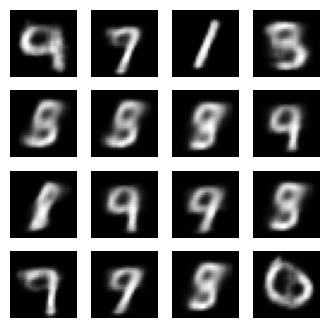

In [19]:
generate_and_save_images(model, 0, test_sample)

for epoch in range(1, epochs + 1):
  start_time = time.time()
  for train_x in train_dataset:
    train_step(model, train_x, optimizer)
  end_time = time.time()

  loss = tf.keras.metrics.Mean()
  for test_x in test_dataset:
    loss(compute_loss(model, test_x))
  elbo = -loss.result()
  display.clear_output(wait=False)
  print('Epoch: {}, Test set ELBO: {}, time elapse for current epoch: {}'
        .format(epoch, elbo, end_time - start_time))
  generate_and_save_images(model, epoch, test_sample)